# Data Understanding & Preparation

In [2]:
#import the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
# Import the CSV files
df = pd.read_csv('online_retail_II.csv')

In [4]:
# Get the shape of the dataframe
df.shape

(1067371, 8)

In [5]:
# Get the head of the dataframe
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
# Get the tail of the dataframe
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [7]:
# get the information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [8]:
# Get the statistic summary of the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


<Axes: >

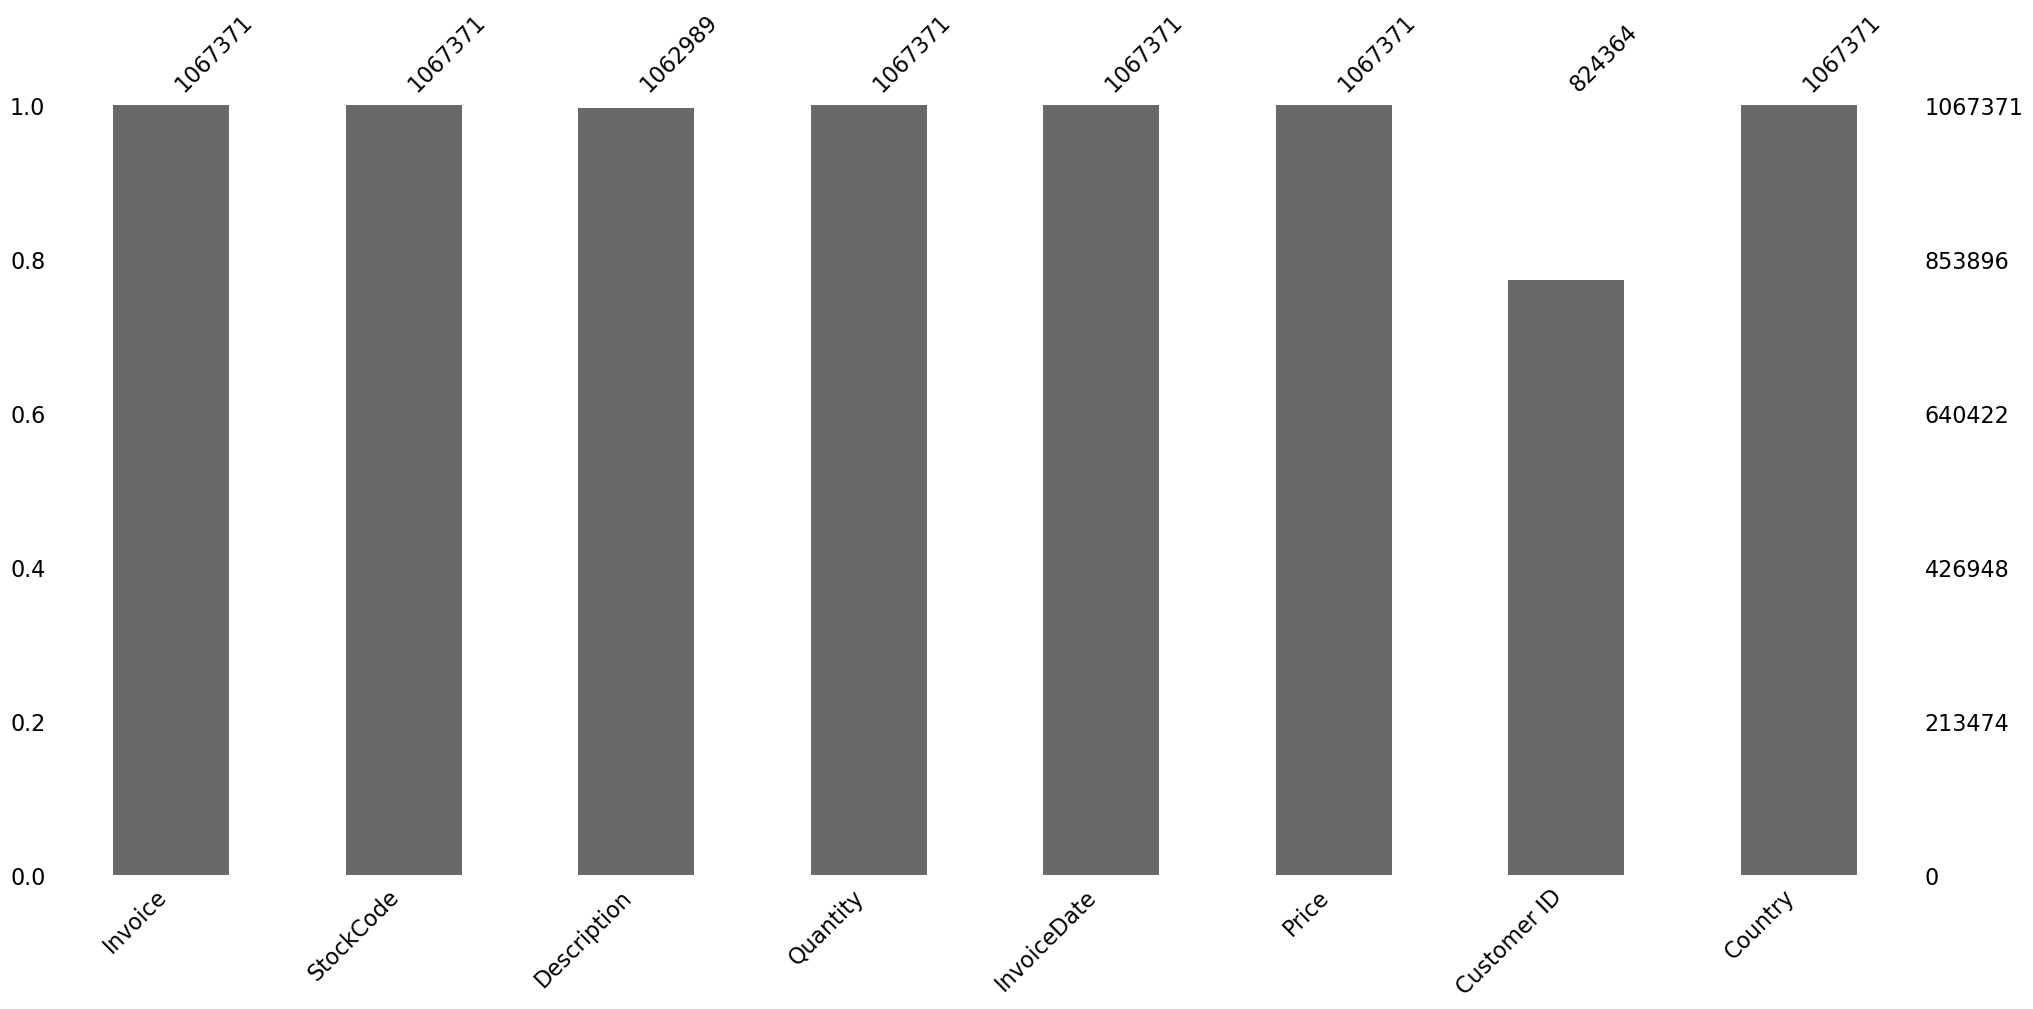

In [9]:
# Visualize the missing value
import missingno as msno
msno.bar(df)

In [10]:
# Removing the missing row from Customer ID
df.dropna(subset='Customer ID', inplace=True)

In [11]:
# Removing the canceled transaction
df = df[~df['Invoice'].str.contains('C')]

In [12]:
# Change the Invoice Date column type to date time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [13]:
# Preview the final dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805620 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  float64       
 7   Country      805620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


# RFM Analysis

In [14]:
# Making the total amount feature
df['Total Amount'] = df['Quantity'] * df['Price']

In [15]:
# Preview the last purchase made in the dataframe
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [16]:
# Making the reference date for counting recency (since it's an old data, we could make the reference date is 1 one day after the last purchase)
from datetime import timedelta
reference_date = df['InvoiceDate'].max() + timedelta(days=1)

In [17]:
# Create RFM dataframe
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice' : 'count',
    'Total Amount' : 'sum'
})
rfm = rfm.rename(columns={'InvoiceDate':'Recency', 'Invoice':'Frequency', 'Total Amount':'Monetary'})
rfm

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,34,77556.46
12347.0,2,253,5633.32
12348.0,75,51,2019.40
12349.0,19,175,4428.69
12350.0,310,17,334.40
...,...,...,...
18283.0,4,986,2736.65
18284.0,432,28,461.68
18285.0,661,12,427.00


In [18]:
# Define quantile
kuartil = rfm.quantile([0.25, 0.5, 0.75])

# assign RFM scores
def Rscore(x, p, d):
    if p == 'Recency':
        if x <= d[p][0.25]:
            return 4
        elif x <= d[p][0.50]:
            return 3
        elif x <= d[p][0.75]:
            return 2
        else:
            return 1
    else:
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]:
            return 3
        else:
            return 4

# Create new features for RFM score with assigned function
rfm['R'] = rfm['Recency'].apply(Rscore, args=('Recency', kuartil))
rfm['F'] = rfm['Frequency'].apply(Rscore, args=('Frequency', kuartil))
rfm['M'] = rfm['Monetary'].apply(Rscore, args=('Monetary', kuartil))
rfm

,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
12346.0,326,34,77556.46,2,2,4
12347.0,2,253,5633.32,4,4,4
12348.0,75,51,2019.40,3,2,3
12349.0,19,175,4428.69,4,4,4
12350.0,310,17,334.40,2,1,1
...,...,...,...,...,...,...
18283.0,4,986,2736.65,4,4,4
18284.0,432,28,461.68,1,2,2
18285.0,661,12,427.00,1,1,2


In [19]:
# Combining all the RFM score for each customer
rfm['Total Score'] = rfm['R'] + rfm['F'] + rfm['M']
rfm['Category'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm

,Recency,Frequency,Monetary,R,F,M,Total Score,Category
Customer ID,,,,,,,,
12346.0,326,34,77556.46,2,2,4,8,224
12347.0,2,253,5633.32,4,4,4,12,444
12348.0,75,51,2019.40,3,2,3,8,323
12349.0,19,175,4428.69,4,4,4,12,444
12350.0,310,17,334.40,2,1,1,4,211
...,...,...,...,...,...,...,...,...
18283.0,4,986,2736.65,4,4,4,12,444
18284.0,432,28,461.68,1,2,2,5,122
18285.0,661,12,427.00,1,1,2,4,112


In [20]:
# Creating segmented customer based on RFM score
def Rsegment(x):
    if x >= 10:
        return 'Loyal Customer'
    elif x >= 7:
        return 'Potensial Customer'
    elif x >= 4:
        return 'Active Customer'
    else:
        return 'Inactive Customer'

rfm['Segment'] = rfm['Total Score'].apply(Rsegment)

C:\Users\trian\AppData\Local\Temp\ipykernel_33060\3944791697.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
C:\Users\trian\AppData\Local\Temp\ipykernel_33060\3944791697.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)


[Text(0, 0.0, '0'),
 Text(0, 250.0, '250'),
 Text(0, 500.0, '500'),
 Text(0, 750.0, '750'),
 Text(0, 1000.0, '1000'),
 Text(0, 1250.0, '1250'),
 Text(0, 1500.0, '1500'),
 Text(0, 1750.0, '1750'),
 Text(0, 2000.0, '2000')]

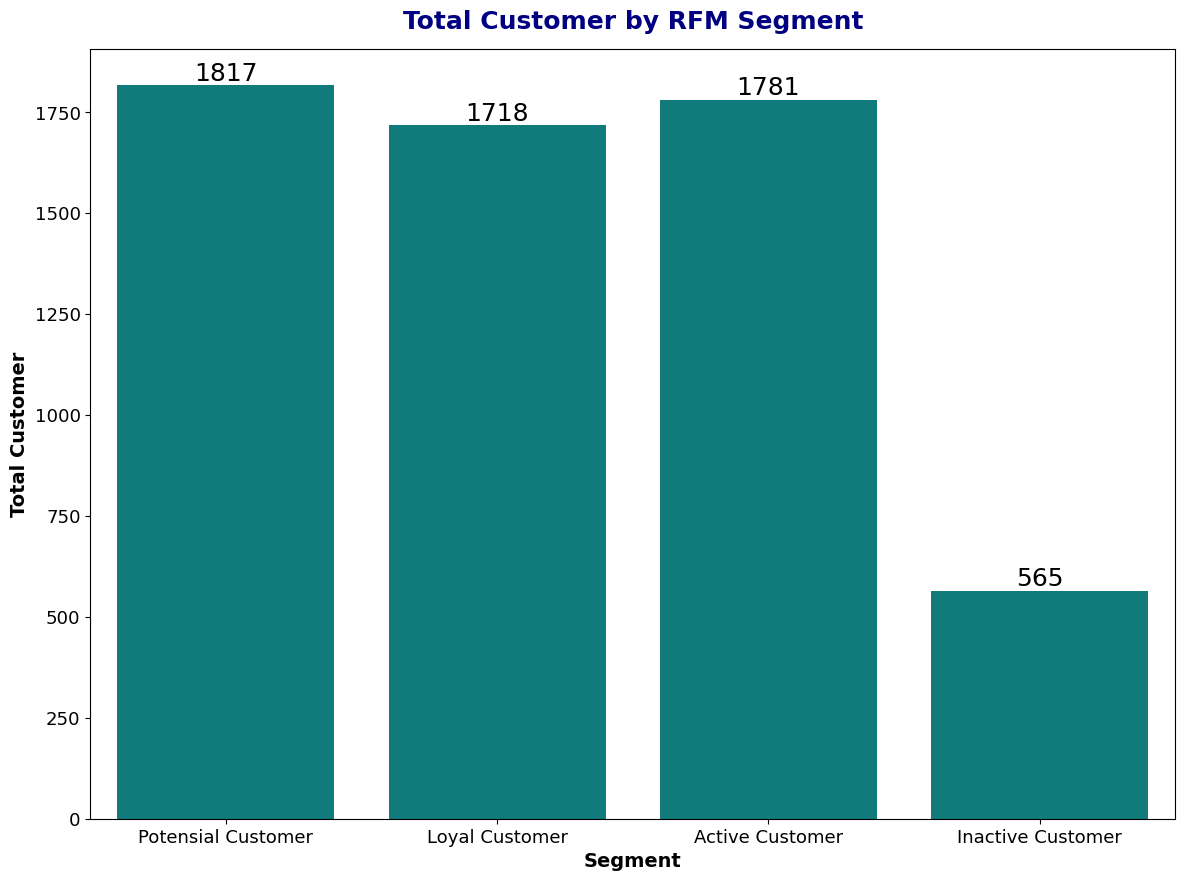

In [21]:
# Creating the visualization
fig, ax = plt.subplots(figsize=(14, 10))

ax = sns.countplot(rfm, x='Segment', color='darkcyan')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=18)

plt.title('Total Customer by RFM Segment', fontsize=18, color='navy', weight='bold', y=1.015)
ax.set_xlabel('Segment', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Customer', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)

# Churn Prediction Model

In [23]:
# assign features needed into churn variable
avg_quantity = df.groupby('Customer ID')['Quantity'].mean()
country = df.groupby('Customer ID')['Country'].agg('first')
treshold = rfm['Recency'].quantile(0.75)
is_churn = rfm['Recency'].apply(lambda x: 1 if x > treshold else 0)
churn = pd.DataFrame({
    'Recency': rfm['Recency'],
    'Frequency': rfm['Frequency'],
    'Monetary': rfm['Monetary'],
    'Country': country,
    'avg_quantity': avg_quantity,
    'is_churn': is_churn
})

#Making the copy of churn dataframe so that the feature engineering doesn't alter the original dataframe
churn_model = churn.copy()

In [24]:
# Adding noise for the dataset
np.random.seed(42)
noise = np.random.binomial(1, 0.1, size=len(churn_model))  # 10% random noise
churn_model['is_churn'] = np.where(churn_model['Recency'] > treshold, 1, 0)
churn_model['is_churn'] = np.where(noise == 1, 1 - churn_model['is_churn'], churn_model['is_churn'])

In [25]:
# Create one hot encoding for the country column
churn_model = pd.get_dummies(churn_model, columns=['Country'], drop_first=True)

In [26]:
# Creating independent features
features = ['Recency', 'Monetary', 'avg_quantity', 'Country_Austria', 'Country_Bahrain', 'Country_Belgium',
       'Country_Brazil', 'Country_Canada', 'Country_Channel Islands',
       'Country_Cyprus', 'Country_Czech Republic', 'Country_Denmark',
       'Country_EIRE', 'Country_European Community', 'Country_Finland',
       'Country_France', 'Country_Germany', 'Country_Greece',
       'Country_Iceland', 'Country_Israel', 'Country_Italy', 'Country_Japan',
       'Country_Korea', 'Country_Lebanon', 'Country_Lithuania',
       'Country_Malta', 'Country_Netherlands', 'Country_Nigeria',
       'Country_Norway', 'Country_Poland', 'Country_Portugal', 'Country_RSA',
       'Country_Saudi Arabia', 'Country_Singapore', 'Country_Spain',
       'Country_Sweden', 'Country_Switzerland', 'Country_Thailand',
       'Country_USA', 'Country_United Arab Emirates', 'Country_United Kingdom',
       'Country_Unspecified', 'Country_West Indies']

# Assign the dependent and independent features to it's variable
X = churn_model[features]
y = churn_model['is_churn']

In [27]:
# Import model library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Normalize the dataset for machine learning model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Assign random forrest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [31]:
# Creating confussion matrix, classification report, and accuracy score to it's variable
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [32]:
# Save the churn prediction model
import joblib

joblib.dump(model, 'churn_prediction_model.pk1')

['churn_prediction_model.pk1']

In [33]:
# Print the model's report variable
print(conf_matrix)
print(class_report)
print(accuracy)

[[774  39]
 [ 98 266]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       813
           1       0.87      0.73      0.80       364

    accuracy                           0.88      1177
   macro avg       0.88      0.84      0.86      1177
weighted avg       0.88      0.88      0.88      1177

0.8836023789294817


Text(0.5, 0, 'Percentages')

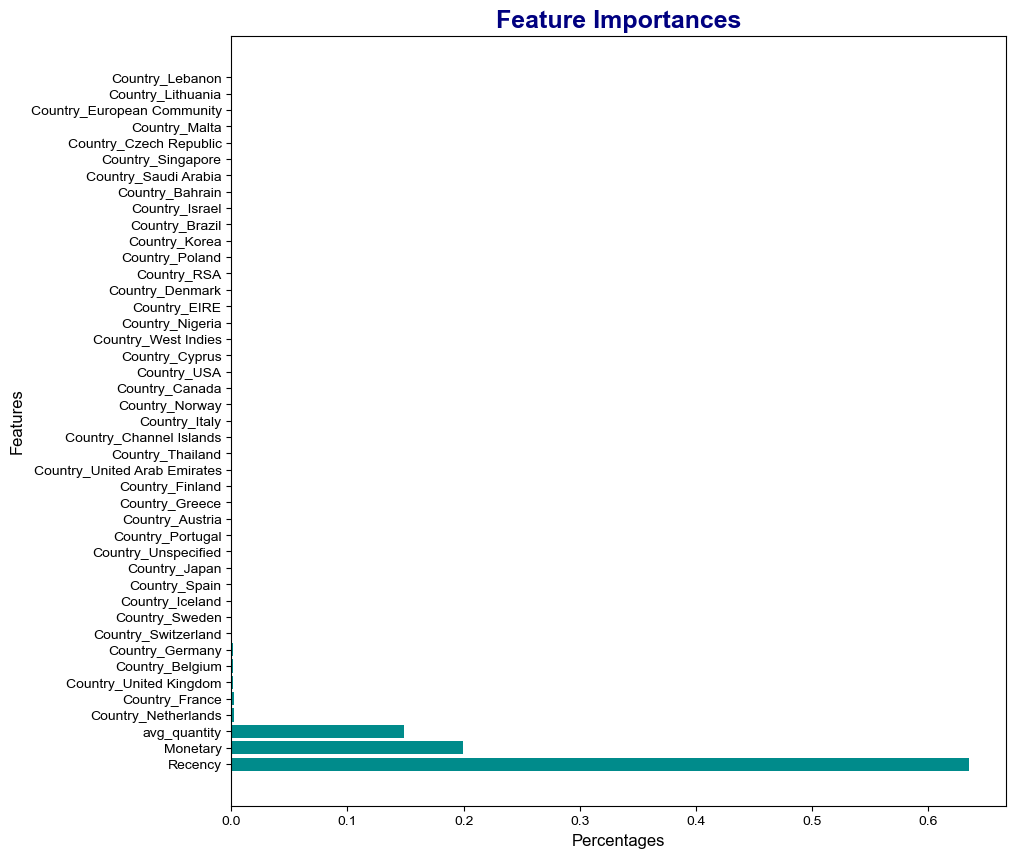

In [34]:
# Checking feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

# plot the feature importances
plt.figure(figsize=(10,10))
plt.title('Feature Importances', fontsize=18, color='Navy', fontweight='bold')
plt.barh(range(X.shape[1]), importances[indices], color='darkcyan')
plt.yticks(range(X.shape[1]), names)
plt.ylabel('Features', fontsize=12)
plt.xlabel('Percentages', fontsize=12)

In [35]:
# assign the churn prediction model to original dataframe by creating new features
y_pred_proba = model.predict_proba(X)
churn_prediction_rate = y_pred_proba[:, 1]
churn['churn_prediction_rate'] = churn_prediction_rate * 100
churn

c:\Users\trian\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Recency,Frequency,Monetary,Country,avg_quantity,is_churn,churn_prediction_rate
Customer ID,,,,,,,
12346.0,326,34,77556.46,United Kingdom,2184.852941,0,56.0
12347.0,2,253,5633.32,Iceland,12.988142,0,56.0
12348.0,75,51,2019.40,Finland,53.215686,0,56.0
12349.0,19,175,4428.69,Italy,9.280000,0,56.0
12350.0,310,17,334.40,Norway,11.588235,0,56.0
...,...,...,...,...,...,...,...
18283.0,4,986,2736.65,United Kingdom,1.757606,0,47.0
18284.0,432,28,461.68,United Kingdom,17.642857,1,56.0
18285.0,661,12,427.00,United Kingdom,12.083333,1,56.0


# Cohort Analysis

In [36]:
# Making copy of the original dataframe and assigned it to new variable
cohort = df.copy()
cohort

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [37]:
# Create an invoice month feature
cohort['Invoice Date'] = cohort['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
cohort


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount,Invoice Date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009-12-01
...,...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-01
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-12-01


In [38]:
# Create a cohort month
cohort['Starting Month'] = cohort.groupby('Customer ID')['Invoice Date'].transform('min')
cohort.tail(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount,Invoice Date,Starting Month
1067361,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France,15.00,2011-12-01,2011-08-01
1067362,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680.0,France,15.60,2011-12-01,2011-08-01
1067363,581587,22629,SPACEBOY LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France,23.40,2011-12-01,2011-08-01
1067364,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01,2011-08-01
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-01,2011-08-01
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-01,2011-08-01
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01,2011-08-01
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01,2011-08-01
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-12-01,2011-08-01
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,18.00,2011-12-01,2011-08-01


In [39]:
# Create a date element function to get a series for substraction
def get_date_elements(df, column):
    month = df[column].dt.month
    year = df[column].dt.year
    return month, year

In [40]:
# Get date elements for substraction
Invoice_Month, Invoice_Year = get_date_elements(cohort, 'Invoice Date')
Cohort_Month, Cohort_Year = get_date_elements(cohort, 'Starting Month')

In [41]:
# Create a cohort index
year_diff = Invoice_Year - Cohort_Year
month_diff = Invoice_Month - Cohort_Month

# Substracting the last and starting invoice year and month 
cohort['Cohort Index'] = year_diff*12+month_diff 

In [42]:
# Create new dataframe by grouping starting month, cohort index, and customer ID
cohort_data = cohort.groupby(['Starting Month', 'Cohort Index'])['Customer ID'].apply(pd.Series.nunique).reset_index()


In [43]:
# Create a pivot table and assign it to new variable
cohort_table = cohort_data.pivot(index='Starting Month', columns=['Cohort Index'], values='Customer ID')

# Convert cohort values to retention percentage:
# Eacyh value in the row is divided by the number of customers in the first month of the cohort
cohort_table = cohort_table.divide(cohort_table.iloc[:,0], axis=0) * 100

# Format the index (usually the cohort month) to 'Month Year' format for better readability in visualization
cohort_table.index = cohort_table.index.strftime('%B %Y')

# Convert percentage values to proportion (0-1) for heatmap visualization
cohort_table = cohort_table / 100

Text(234.81597222222223, 0.5, 'Starting Date')

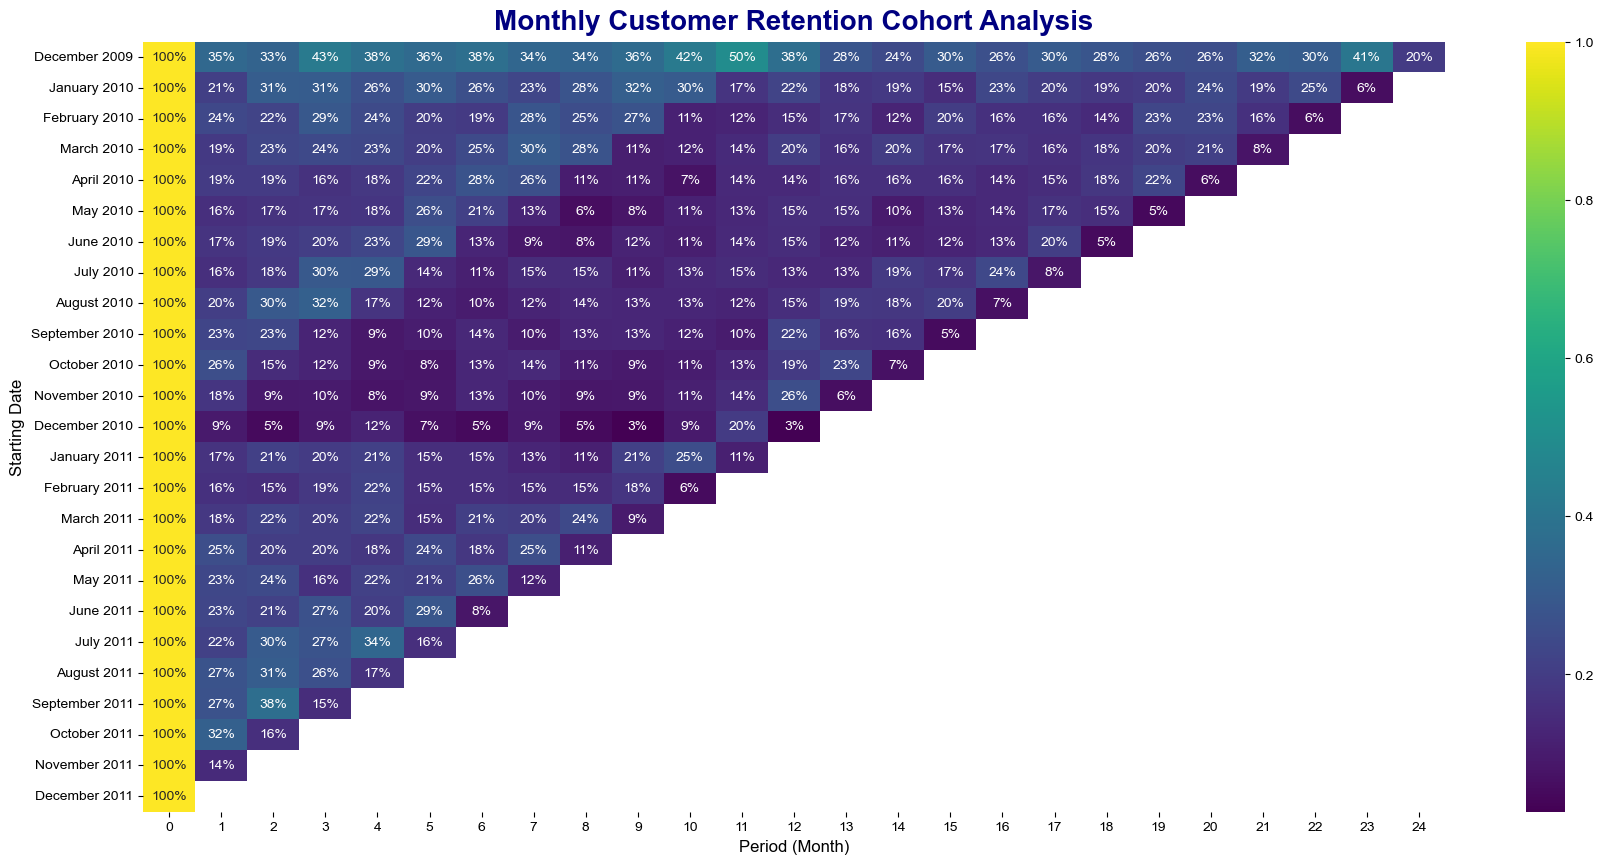

In [44]:
# Visualize the cohort table into heatmap
fig, ax, = plt.subplots(figsize=(21, 10))
ax = sns.heatmap(cohort_table, annot=True, fmt='.0%', cmap='viridis')
plt.title('Monthly Customer Retention Cohort Analysis', fontsize=20, weight='bold', y=1.005, color='Navy')
ax.set_xlabel('Period (Month)', fontsize=12)
ax.set_ylabel('Starting Date', fontsize=12)

# Customer Live Time Value

In [45]:
# For this analysis, we will assign recency, frequency, and monetary to the CLV variable as a new dataframe
clv = rfm[['Recency', 'Frequency', 'Monetary']] # Extract relevant columns from the RFM dataframe
clv

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,34,77556.46
12347.0,2,253,5633.32
12348.0,75,51,2019.40
12349.0,19,175,4428.69
12350.0,310,17,334.40
...,...,...,...
18283.0,4,986,2736.65
18284.0,432,28,461.68
18285.0,661,12,427.00


In [46]:
# Calculate the age of each customer in days
max_date = df['InvoiceDate'].max() # Get the latest transaction date

# Calculate customer age as the difference between the latest and first transaction dates
clv['Customer_Age'] = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (max_date-x.min()).days})

C:\Users\trian\AppData\Local\Temp\ipykernel_33060\1206996855.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clv['Customer_Age'] = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (max_date-x.min()).days})


In [47]:
# Convert customer age from days to years
clv['Customer_Lifespan_Years'] = clv['Customer_Age'] / 365

C:\Users\trian\AppData\Local\Temp\ipykernel_33060\1234163129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clv['Customer_Lifespan_Years'] = clv['Customer_Age'] / 365


In [48]:
# Calculate Customer Lifetime Value (CLV)
clv['CLV'] = clv['Monetary'] * clv['Customer_Lifespan_Years'] # Compute CLV by multiplying monetary value by customer lifespan in years

C:\Users\trian\AppData\Local\Temp\ipykernel_33060\4145667927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clv['CLV'] = clv['Monetary'] * clv['Customer_Lifespan_Years'] # Compute CLV by multiplying monetary value by customer lifespan in years


In [49]:
# Round the CLV values to 2 decimal palces for better readability
clv['CLV'] = clv['CLV'].round(2)

C:\Users\trian\AppData\Local\Temp\ipykernel_33060\3062554262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clv['CLV'] = clv['CLV'].round(2)


In [50]:
# Add churn prediction rate to the CLV dataframe
clv['Churn_Prediction_Rate'] = churn['churn_prediction_rate']

C:\Users\trian\AppData\Local\Temp\ipykernel_33060\1379930176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clv['Churn_Prediction_Rate'] = churn['churn_prediction_rate']


In [51]:
# Create a copy of the CLV dataframe for segmentation purposes
clv_segment = clv.copy()

In [52]:
# Segment customers based on their CLV values
clv_segment['CLV_segment'] = clv['CLV'].apply(lambda x: 'Bronze' if x <= 290 else 'Silver' if x <= 1010 else 'Gold' if x <= 3458 else 'Platinum')

In [53]:
# Segment customers based on their churn risk
clv_segment['Churn_Risk'] = clv['Churn_Prediction_Rate'].apply(lambda x: 'Low Risk' if x <= 55 else 'Medium Risk' if x <= 75 else 'High Risk')

In [54]:
# Combine CLV segment and churn risk into a single customer segment
clv_segment['Customer_Segment'] = clv_segment['CLV_segment'] + '-' + clv_segment['Churn_Risk']

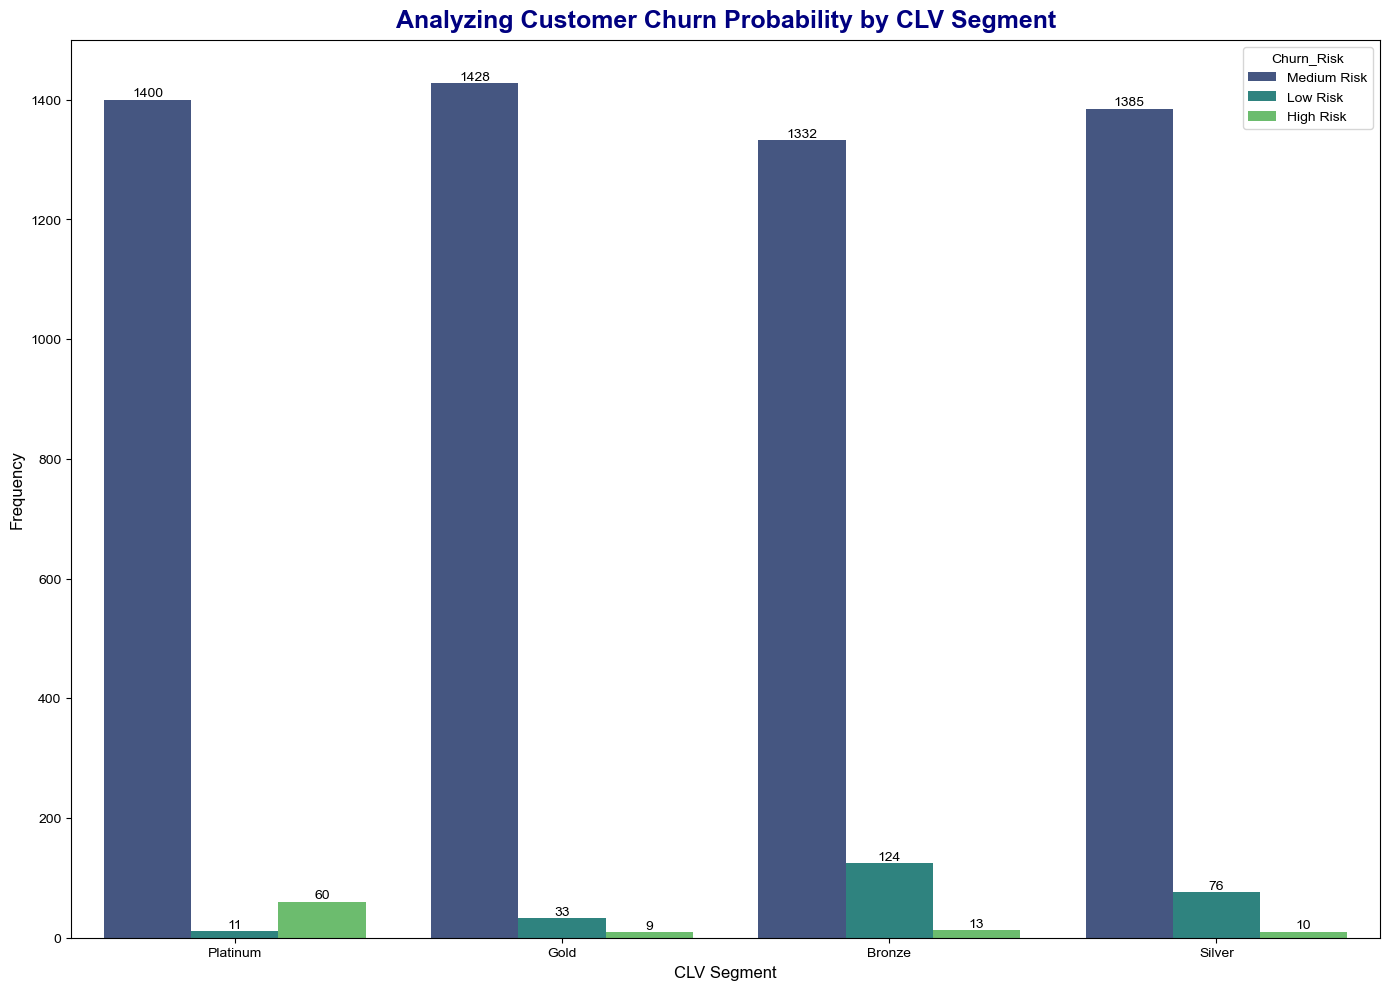

In [55]:
# Visualize the count of customer in each CLV segment with churn risk
fig, ax = plt.subplots(figsize=(14, 10))
ax = sns.countplot(clv_segment, x='CLV_segment', hue='Churn_Risk', palette='viridis')
for container in ax.containers:
    ax.bar_label(container, fmt='%d') # add labels to the bars to show the count of customer


plt.title('Analyzing Customer Churn Probability by CLV Segment', fontsize=18, fontweight='bold', y=1.005, color='navy')
ax.set_xlabel('CLV Segment', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()

In [56]:
# Define a function to simulate retention uplift for a specific segment and risk level
def simulate_retention_uplift(df, segment, risk_level, retention_increase_percent):
    # Create a mask to filter the specific segment and risk level
    segment_mask = clv_segment['CLV_segment'] == f'{segment}-{risk_level}'
    df_result = clv_segment.copy()

    # Calculate new churn probability after retention increase
    df_result['Churn_Prob_New'] = df_result.apply(
        lambda row: row['Churn_Prediction_Rate'] * (1 - retention_increase_percent / 100)
        if row['Customer_Segment'] == f"{segment}-{risk_level}"
        else row['Churn_Prediction_Rate'],
        axis=1)

    # Calculate expected revenue before and after retention increase
    df_result['Expected_Revenue_Before'] = df_result['CLV'] * (1- df_result['Churn_Prediction_Rate'])
    df_result['Expected_Revenue_After'] = df_result['CLV'] * (1 - df_result['Churn_Prob_New'])
    df_result['Revenue_Uplift'] = df_result['Expected_Revenue_After'] - df_result['Expected_Revenue_Before']

    # Calculate total revenue uplift for the specific segment and risk level
    segment_mask = df_result['Customer_Segment'] == f"{segment}-{risk_level}"
    total_uplift = df_result.loc[segment_mask, 'Revenue_Uplift'].sum()

    # Return the results as a dictionary
    return {
    'Segment': f'{segment}-{risk_level}',
    'Retention_Increase': retention_increase_percent,
    'Revenue_Uplift': total_uplift
    }

In [57]:
# Define the segments and retention increase levels for simulation
segments = [
    ('Platinum', 'High Risk'),
    ('Platinum', 'Medium Risk'),
    ('Gold', 'High Risk'),
    ('Gold', 'Medium Risk')
]
retention_increase_levels = [10, 20, 30] # Define retention increase percentages

# Run the simulation for all combinations of segments and retention levels
results = []

for segment, risk, in segments:
    for retention_increase in retention_increase_levels:
        result = simulate_retention_uplift(clv_segment, segment, risk, retention_increase)
        results.append(result)

# Convert the results into a dataframe
results_df = pd.DataFrame(results)

In [58]:
# Format the dataframe for better readability
pd.set_option('display.float_format', '{:,.2f}'.format)
results_df

,Segment,Retention_Increase,Revenue_Uplift
0,Platinum-High Risk,10,"32,143,410.47"
1,Platinum-High Risk,20,"64,286,820.94"
2,Platinum-High Risk,30,"96,430,231.41"
3,Platinum-Medium Risk,10,"122,495,913.84"
4,Platinum-Medium Risk,20,"244,991,827.69"
5,Platinum-Medium Risk,30,"367,487,741.53"
6,Gold-High Risk,10,"171,506.28"
7,Gold-High Risk,20,"343,012.56"
8,Gold-High Risk,30,"514,518.84"
9,Gold-Medium Risk,10,"15,616,354.30"


In [59]:
# Add a column to convert revenue uplift to millions for visualization
results_df['Revenue_Uplift_Million'] = results_df['Revenue_Uplift']/1_000_000
results_df = results_df.sort_values(by='Segment') # sort the dataframe by segment for better visualization

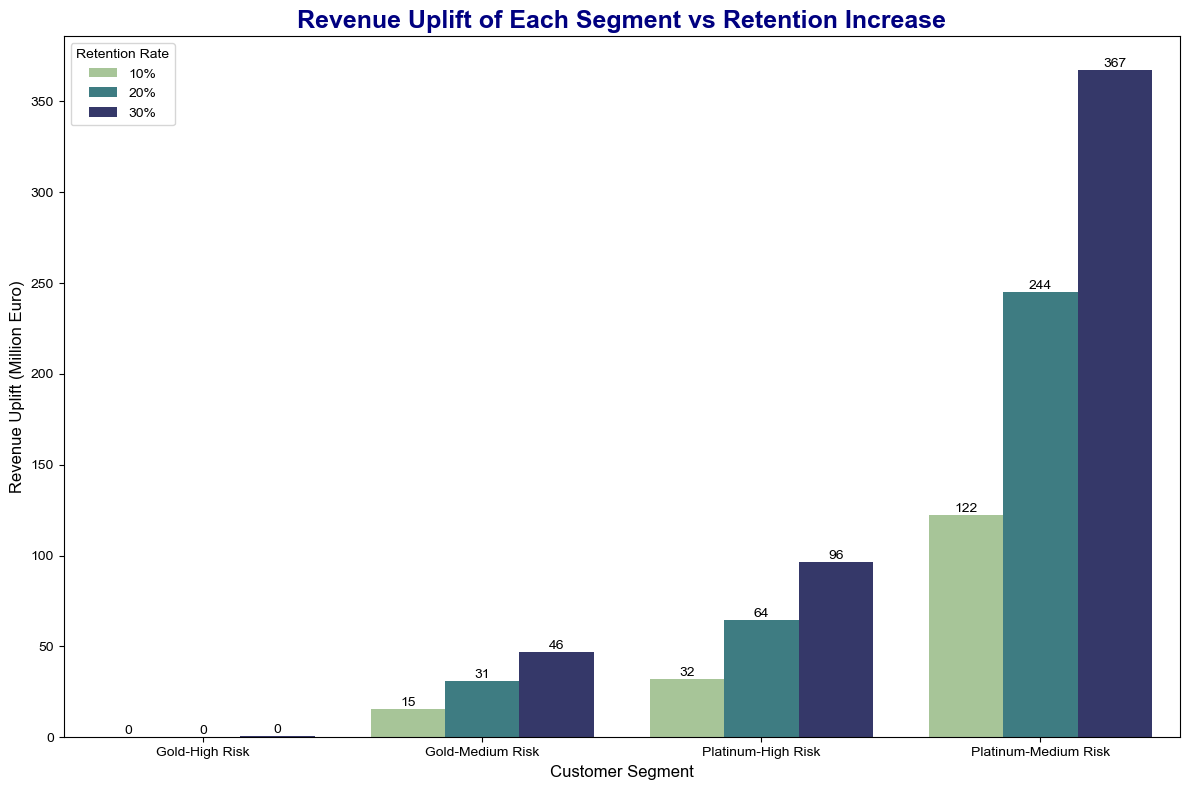

In [60]:
# Visualize the revenue uplift for each segment and retention increase level
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(results_df, x='Segment', y='Revenue_Uplift_Million', hue='Retention_Increase', palette='crest')

for container in ax.containers:
    ax.bar_label(container, fmt='%d') # Add labels to the bars to show revenue uplift

legend = ax.legend(title='Retention Rate')

texts = legend.get_texts()
texts[0].set_text('10%')
texts[1].set_text('20%')
texts[2].set_text('30%')
plt.title('Revenue Uplift of Each Segment vs Retention Increase', fontsize=18, fontweight='bold', color='navy')
ax.set_xlabel('Customer Segment', fontsize=12)
ax.set_ylabel('Revenue Uplift (Million Euro)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Note: The 'Gold-High Risk' segment has a very small revenue uplift value, which might not be visible in the barplot